In [50]:
import pangolin
from pangolin import interface as pi

In [51]:
# data
num_schools = 8
observed = [28, 8, -3, 7, -1, 1, 18, 12]
stddevs = [15, 10, 16, 11, 9, 11, 10, 18]

The eight schools model was proposed by [Rubin in 1981](https://doi.org/10.2307/1164617).

That there are eight schools, each of which ran some program to prepare students for the
SAT. Each school estimated a treatment effect (given as `observed` above) and had
some measurement error (given as `stddevs` above). (In Rubin's original paper these
were real numbers, but at some point people turned them into integers, and I'll keep using
integers for consistency.)

It is assumed that the programs have different effectiveness in different schools. But probably
not *that* different.

The model is typically written like this:

$
\begin{align}
\mu \sim & \mathrm{Normal(0,10)} & \\
\tau \sim & \mathrm{Lognormal(5,1)} & \\
\theta_i \sim & \mathrm{Normal}(\mu,\tau),& \quad 1 \leq i\leq 8 \\
y_i \sim & \mathrm{Normal}(\theta_i, \sigma_i),& \quad 1 \leq i\leq 8
\end{align}
$

Here $\mu$ represents the "typical" effectiveness of the program, while $\theta_i$ represents the
 actual effectivenes for school $i$ and $y_i$ is the measured effectivness with noise. $\tau$
 represents the variability of effectiveness from school to school.

In Tensorflow Probability, the model is written in a [comically complicated way](https://www.tensorflow.org/probability/examples/Eight_Schools).

In [52]:
# define model
mu = pi.normal(0,10)
tau = pi.exp(pi.normal(5,1))
theta = [pi.normal(mu,tau) for i in range(num_schools)]
y = [pi.normal(theta[i],stddevs[i]) for i in range(num_schools)]

In [53]:
# mu, tau, theta[i], and y[i] are each scalar random variables.
# if you call print_upstream() on any group of RVs, it will 
# do a graph search and find everything above.

pi.print_upstream(y)

shape | statement
----- | ---------
()    | a = 0
()    | b = 10
()    | c ~ normal(a,b)
()    | d = 5
()    | e = 1
()    | f ~ normal(d,e)
()    | g = exp(f)
()    | h ~ normal(c,g)
()    | i = 15
()    | j ~ normal(h,i)
()    | k ~ normal(c,g)
()    | l = 10
()    | m ~ normal(k,l)
()    | n ~ normal(c,g)
()    | o = 16
()    | p ~ normal(n,o)
()    | q ~ normal(c,g)
()    | r = 11
()    | s ~ normal(q,r)
()    | t ~ normal(c,g)
()    | u = 9
()    | v ~ normal(t,u)
()    | w ~ normal(c,g)
()    | x = 11
()    | y ~ normal(w,x)
()    | z ~ normal(c,g)
()    | ba = 10
()    | bb ~ normal(z,ba)
()    | bc ~ normal(c,g)
()    | bd = 18
()    | be ~ normal(bc,bd)


In [54]:
# do inference using pangolin's interface to blackjax
theta_samps = pangolin.blackjax.sample(theta, y, observed, niter=10000)

In [55]:
# Since theta is a list of 8 scalar RVs, you get back a list of 8 length 10000 Numpy arrays,
# each containing samples or 1 RV / school.
[s.shape for s in theta_samps] == [(10000,)] * 8

True

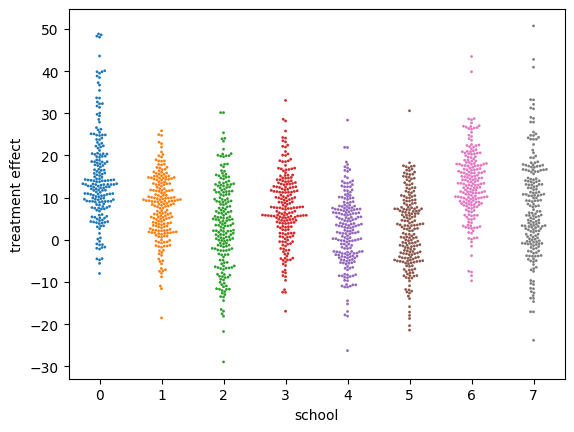

In [56]:
# plot the results (pangolin not used here!)
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
sns.swarmplot(np.array(theta_samps)[:,::50].T,s=2,zorder=0)
plt.xlabel('school')
plt.ylabel('treatment effect');

Notice:
* Schools with high observed effects get pulled down towards the overall mean (like school 0 with an observed effect of 28)
* Schools with low observed effects get pulled up towards the overall mean (like school 2 with an observed effect of -3)
* Schools with lower standard deviations have tighter posteriors. (School 4 has a stddev of 9, while school 7 has a stddev of 18)

Bayes works!

Instead of unrolling everything, you can also define the model using vmap. This will be *much* more efficient in large models.

In [57]:
mu = pi.normal(0,10)
tau = pi.exp(pi.normal(5,1))
theta = pi.vmap(pi.normal, None, axis_size=8)(mu, tau)
y = pi.vmap(pi.normal)(theta, pi.constant(stddevs))

Now, you can see that instead of everything being scalar, the internal representation involves three vector-valued RVs of length 8. To make things nicer, let's pass variable names when printing all the nodes.

In [58]:
pi.print_upstream(mu=mu, tau=tau, theta=theta, y=y)

shape | statement
----- | ---------
()    | a = 0
()    | b = 10
()    | mu ~ normal(a,b)
()    | c = 5
()    | d = 1
()    | e ~ normal(c,d)
()    | tau = exp(e)
(8,)  | theta ~ vmap(normal, (None, None), 8)(mu,tau)
(8,)  | f = [15 10 ... 10 18]
(8,)  | y ~ vmap(normal, (0, 0), 8)(theta,f)


In [59]:
# inference
theta_samps = pangolin.blackjax.sample(theta, y, np.array(observed), niter=10000)

In [60]:
# now, the samples are one big array
theta_samps.shape

(10000, 8)

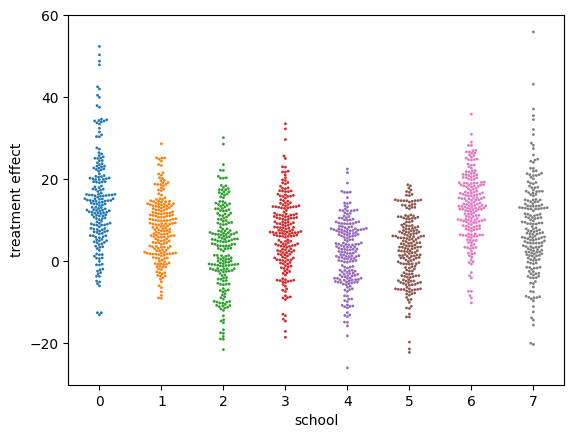

In [61]:
# plot
sns.swarmplot(theta_samps[::50,:],s=2)
plt.xlabel('school')
plt.ylabel('treatment effect');